# Evaluate self-attention

Here we want to evaluate the benefits of placing a self-attention layer instead of or after the last contraction block.

As usual, we will compare the models performances using the AU-ROC metrics. The models will be:
- 3 contraction blocks (control)
- 3 contraction blocks + a self-attention layer
- 2 contraction blocks + a self-attention layer.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.classification import AUCCallback
from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.metrics.AU_ROC import compute_ROC, compute_AUC, plot_ROC
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.visualisation.tSNE import plot_tSNE

!nvidia-smi

2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tue Jul 14 08:06:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

x_val, y_val = x_train[-1000:], binarize_set(y_train[-1000:], interest=0)
y_test0 = binarize_set(y_test)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

# training set contains only zeros (for training on zeros)
x_train0, y_train0 = digits_train[0][:-1000], y_train[np.where(y_train[:-1000] == 0)][:-1000]

print(x_train0.shape, y_train0.shape, x_val.shape, y_val.shape)
print(y_test[:5], y_test0[:5])

11493376/11490434 [==============================] - 0s 0us/step
(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)
[7 2 1 0 4] [1 1 1 0 1]


In [43]:
from tensorflow.keras.layers import Layer, Dense, Reshape, Embedding, Concatenate, Conv2D

class SelfAttention(Model):
    def __init__(self, d_model, spatial_dims, positional_encoding=True, name="self_attention"):
        '''
            d_model : number of output channels
            spatial_dim : spatial dimensions of input tensor (x, y)
            if positional_encoding: depth must correspond to input channel number
            adapted from: https://www.tensorflow.org/tutorials/text/transformer
        '''
        super().__init__(name=name)
        self.d_model = d_model
        self.spatial_dims=spatial_dims
        self.spatial_dim = np.prod(spatial_dims)
        self.wq = Dense(self.d_model, name=name+"_q")
        self.wk = Dense(self.d_model, name=name+"_k")
        self.wv = Dense(self.d_model, name=name+"_w")
        self.positional_encoding=positional_encoding
        if positional_encoding:
            self.pos_embedding = Embedding(self.spatial_dim, d_model, name=name+"pos_enc") # TODO test other positional encoding. in particular that encodes X and Y

    def call(self, x):
        '''
            x : tensor with shape (batch_size, y, x, channels)
        '''
        shape = tf.shape(x)
        batch_size = shape[0]
        #spatial_dims = shape[1:-1]
        #spatial_dim = tf.reduce_prod(spatial_dims)
        depth_dim = shape[3]

        if self.positional_encoding:
            x_index = tf.range(self.spatial_dim, dtype=tf.int32)
            pos_emb = self.pos_embedding(x_index) # (spa_dim, d_model)
            pos_emb = tf.reshape(pos_emb, (self.spatial_dims[0], self.spatial_dims[1], self.d_model)) #for broadcasting purpose
            x = x + pos_emb # broadcast

        q = self.wq(x)  # (batch_size, *spa_dims, d_model)
        k = self.wk(x)  # (batch_size, *spa_dims, d_model)
        v = self.wv(x)  # (batch_size, *spa_dims, d_model)

        q = tf.reshape(q, (batch_size, -1, depth_dim)) # (batch_size, spa_dim, d_model)
        k = tf.reshape(k, (batch_size, -1, depth_dim))
        v = tf.reshape(v, (batch_size, -1, depth_dim))

        # scaled_attention.shape == (batch_size, spa_dims, depth)
        # attention_weights.shape == (batch_size, spa_dims, spa_dims)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v)
        output = tf.reshape(scaled_attention, (batch_size, self.spatial_dims[0], self.spatial_dims[1], self.d_model))
        tf.identity(attention_weights, name=self.name+"_attention_weights")
        # return output, attention_weights
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]+(self.d_model,), (input_shape[0],self.spatial_dim,self.spatial_dim)

def scaled_dot_product_attention(q, k, v):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.
    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    Returns:
    output, attention_weights
    from : https://www.tensorflow.org/tutorials/text/transformer
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [52]:
from uad.models.variational_autoencoder import VAE, Sampling

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation1="sigmoid",
                 activation2="sigmoid"):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation1 != "":
        x = layers.Activation(activation1)(x)

    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation2 != "":
        x = layers.Activation(activation2)(x)

    return x

def build_VAE(n_contractions=3, self_attention=False):
    latent_dim = 8
    # WARNIING : if latent_side used during model declaration is not equal to
    # the input => weird things happen and the predictions are all wrong
    latent_side = int(2 ** (5 - n_contractions))
    print(latent_side)
    batchnorm = False
    dropout = 0.2
    k_size = 3
    n_filters = 16

    act1, act2, final_activation = "sigmoid", "sigmoid", "sigmoid"

    encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_inputs")

    paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
    x = tf.pad(encoder_inputs, paddings, name="pad")

    for k in range(n_contractions):
        x = conv2d_block(x, n_filters * (2**k), kernel_size=k_size, batchnorm=batchnorm, 
                     activation1=act1, activation2=act2)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(dropout)(x)

    if self_attention:
      if n_contractions == 2:
        s = SelfAttention(32, (latent_side, latent_side), positional_encoding=True)(x)  # only output
      else:
        s = SelfAttention(64, (latent_side, latent_side), positional_encoding=True)(x)  # only output
      c = Concatenate(axis=-1)([x, s])  # good axis ?
      z_mean = layers.Conv2D(latent_dim, 1, strides=1, name="z_mean")(c)
      z_log_var = layers.Conv2D(latent_dim, 1, strides=1, name="z_log_var")(c)
      z = Sampling()((z_mean, z_log_var))
    else:
      z_mean = layers.Conv2D(latent_dim, 1, strides=1, name="z_mean")(x)
      z_log_var = layers.Conv2D(latent_dim, 1, strides=1, name="z_log_var")(x)
      z = Sampling()((z_mean, z_log_var))

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Define decoder model.
    latent_inputs = layers.Input(shape=(latent_side, latent_side, latent_dim), 
                                 name="z_sampling")
    x = latent_inputs
    
    for k in range(n_contractions, 0, -1):
        x = layers.Conv2DTranspose(n_filters * (2**(k - 1)), (k_size, k_size), strides=(2, 2), 
                               padding='same', name=f"u{n_contractions + k}")(x)
        x = layers.Dropout(dropout)(x)
        if k == 1:
            decoder_outputs = conv2d_block(x, 1, kernel_size=k_size, batchnorm=batchnorm, 
                              activation1=act1, activation2=act2)
        else:
            x = conv2d_block(x, n_filters * (2**(k - 1)), kernel_size=k_size, batchnorm=batchnorm, 
                              activation1=act1, activation2=act2)

    crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

    decoder = Model(inputs=latent_inputs, outputs=crop, name="decoder")

    return VAE(encoder, decoder, latent_dim=latent_dim)


In [54]:
tested_config = [[3, False],
                 [2, True],
                 [3, True]]


models, l_fpr, l_tpr, l_auc = [], [], [], []
for n_contrac, self_att in tested_config:
    print(f"# Contractions: {n_contrac}, Self-attention? {self_att}")
    vae = build_VAE(n_contractions=n_contrac, self_attention=self_att)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    vae.fit(x_train0, x_train0, batch_size=128, epochs=30)
    predictions = vae.predict(x_test)
    fpr, tpr, _ = compute_ROC(x_test, predictions, y_test0, criterion="l2")
    auc = compute_AUC(fpr, tpr)
    models.append(vae)
    l_fpr.append(fpr)
    l_tpr.append(tpr)
    l_auc.append(auc)
    
fprs, tprs, aucs = np.array(l_fpr), np.array(l_tpr), np.array(l_auc)

print(aucs)

# Contractions: 3, Self-attention? False
4
Epoch 1/30
38/38 [==============================] - 1s 24ms/step - loss: 361.1456 - reconstruction_loss: 360.4890 - kl_loss: 0.6566
Epoch 2/30
38/38 [==============================] - 1s 21ms/step - loss: 260.9345 - reconstruction_loss: 258.9201 - kl_loss: 2.0144
Epoch 3/30
38/38 [==============================] - 1s 21ms/step - loss: 224.1772 - reconstruction_loss: 222.2362 - kl_loss: 1.9410
Epoch 4/30
38/38 [==============================] - 1s 20ms/step - loss: 179.8004 - reconstruction_loss: 177.6631 - kl_loss: 2.1373
Epoch 5/30
38/38 [==============================] - 1s 21ms/step - loss: 149.3165 - reconstruction_loss: 146.7245 - kl_loss: 2.5920
Epoch 6/30
38/38 [==============================] - 1s 20ms/step - loss: 135.7351 - reconstruction_loss: 132.8611 - kl_loss: 2.8740
Epoch 7/30
38/38 [==============================] - 1s 20ms/step - loss: 127.1692 - reconstruction_loss: 124.1746 - kl_loss: 2.9946
Epoch 8/30
38/38 [===============

In [56]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/UAD/MNIST/saved_models")

tf.keras.models.save_model(models[0], "vae_3contrac_no_sa")
tf.keras.models.save_model(models[1], "vae_2contrac__sa")
tf.keras.models.save_model(models[2], "vae_3contrac__sa")

INFO:tensorflow:Assets written to: vae_3contrac_no_sa/assets
INFO:tensorflow:Assets written to: vae_2contrac__sa/assets
INFO:tensorflow:Assets written to: vae_3contrac__sa/assets


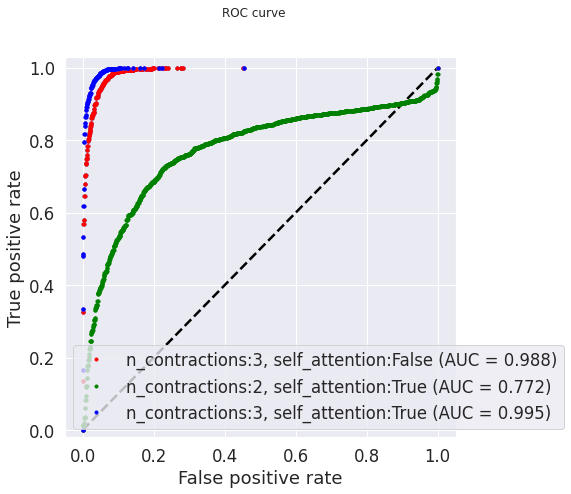

In [57]:
# plot ROC for each dim
labels = [f"n_contractions:{row[0]}, self_attention:{row[1]}" for row in tested_config]
fig, ax = plot_ROC(fprs, tprs, labels)

In [60]:
pred_3c = models[0].predict(x_test)
pred_2c_sa = models[1].predict(x_test)
pred_3c_sa = models[2].predict(x_test)

pred_3c = np.squeeze(pred_3c, -1)
pred_2c_sa = np.squeeze(pred_2c_sa, -1)
pred_3c_sa = np.squeeze(pred_3c_sa, -1)
if x_test.shape == (x_test.shape[0], 28, 28, 1):
  x_test = np.squeeze(x_test, -1)

(10000, 28, 28)


Text(0.5, 1.0, '3 contractions, self-attention')

<Figure size 432x288 with 0 Axes>

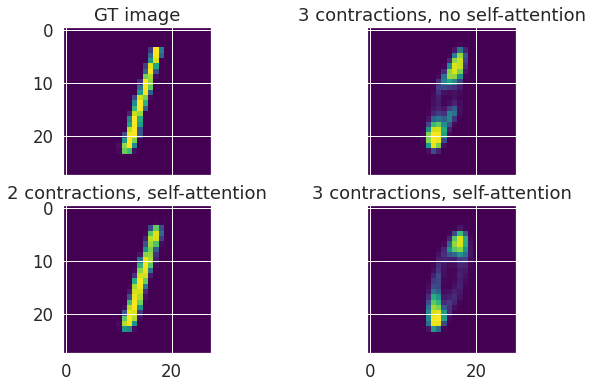

In [66]:
plt.viridis()

idx = 2
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharey="all", sharex="all")
ax[0][0].imshow(x_test[idx])
ax[0][0].set_title("GT image")
ax[0][1].imshow(pred_3c[idx])
ax[0][1].set_title("3 contractions, no self-attention")
ax[1][0].imshow(pred_2c_sa[idx])
ax[1][0].set_title("2 contractions, self-attention")
ax[1][1].imshow(pred_3c_sa[idx])
ax[1][1].set_title("3 contractions, self-attention")

We observe that the 2 contractions/self-attention produces better reconstructions than the two others, but for both 0 digits and non-zero digits. This penalizes it in the classification task based on the reconstruction error. The two other models have similar performances on the task.

t-SNE inputs shape: (10000, 512)
t-SNE inputs shape: (10000, 8)
t-SNE inputs shape: (10000, 8)
t-SNE inputs shape: (10000, 8)


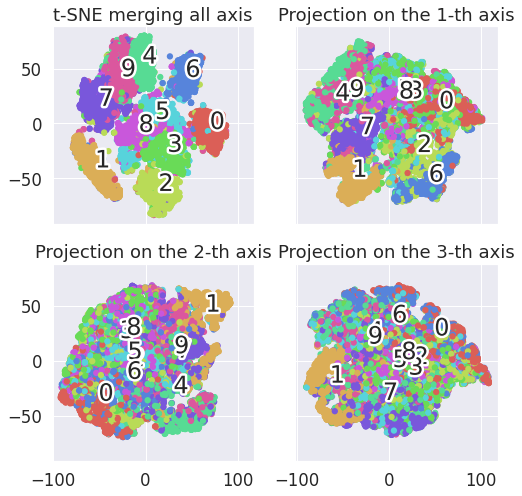

In [67]:
z_means_2c_sa, _, _ = models[1].encoder.predict(x_test)

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey="all", sharex="all")

for i, ax in enumerate(axes.flatten()):
  plot_tSNE(z_means_2c_sa, y_test, axis=i, plt_ax=ax)
  if i == 0:
    ax.set_title("t-SNE merging all axis")
  else:
    ax.set_title(f"Projection on the {i}-th axis")

The clusters are very well formed on the t-SNE projection merging all axis of the 2 contractions/self-attention network. 